#  Notebook Projet Mathématiques : Courbes de Niveaux



### Un projet de Thomas Monnier et Jean Catry


A cause d'une certaine erreur dans contour_simple que nous n'arrivons pas à élucider, nous n'avons pu tester nos fonctions et tenter de tracer des courbes de niveaux sur des fonctions analytiques données. Néanmoins, voici l'ensemble du code qui nous paraît capable d'effectuer cette tâche.

## I. Zones d'importations 

In [114]:
from math import *
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## II. Fonction utilisée

In [115]:
def norm(h):                                          #normalisation vecteur
    x, y = h
    return np.sqrt(x**2 + y**2)


## III. Recherche de la racine


### Amorce :

> Il faut que **f(0,0) < c < f(0,1)** ou **f(0,1) < c < f(0,0)** pour utiliser le __théorème des valeurs intermédiaires__ car *f est continûment différentiable*.

In [116]:
#Méthode de Newton : approximation du zéro rechérché par les zéros des tangentes successives
def find_seed(f, c = 0, eps = 2**(-26)): 
    if f(0, 0) <= c <= f(0, 1)  or f(0, 0) >= c >= f(0, 1):     #condition expliquée ci-haut
        ind = 10**(-4)                                          #pas de la méthode
        t = 0.0         
        def h(x):
            return g(0, x) - c                                  #newton cherche le zéro d'une fonction... donc on crée h
        i = 0
        while abs(h(t)) > eps and i < 100:                      #condition portée sur newton et sur l'arrêt de la fonction
            h_prime = (h(t + ind) - h(t))/ind                 #au cas où Newton n'est pas capable de réussir à trouver le zéro
            t = t - h(t)/h_prime
    else: 
         return None
    return t

On teste find_seed :

In [117]:
def g(x, y):
    return(x**2 + y**2 - 0.5 )
find_seed(g, c = 0, eps = 2**(-26))

0.7071067811881281

 Pour pouvoir appliquer la méthode de Newton à une fonction à deux variables, on va vouloir construire une fonction allant de R² dans R². Or nous travaillons avec une fonction allant de R² dans R. Comment faire ? 
Tout simplement poser g la fonction qui à (x, y) de R² associe (f(x, y), 0).
Dans ce cas, la jacobienne est évidente... et la méthode de Newton qui utiise cette jacobienne est faisable (en théorie) !

### Méthode de Newton de R² vers R²

In [118]:
#Méthode de Newton : approximation du zéro pour une fonction à deux variables
def find_seed_dvar(f, x0, y0, c = 0.0, eps = 2**(-26)):
    def h(x, y):                                 #Fonction de R² dans R
        return( np.array([f(x, y) - c, 0.0]))
    
    x = [x0]
    y = [y0]
    i = 0
    def J_h(x, y):
        j = autograd.jacobian
        return np.c_[j(h, 0)(x, y), j(h, 1)(x, y)]    
                                                      
    while norm(h(x[i], y[i])) > eps:
        J = J_h(x[i], y[i])
       
        #si la matrice jacobienne n'est pas inversible on retourne la meilleure approximation possible
        try:
            J.inv()
        except:
            return x[i], y[i]
        a, b = - h(x[i], y[i])
        c, d = np.linalg.solve(J, np.array[a, b])     
        x.append(c)    
        y.append(d)
        i = i + 1
    return x[-1], y[-1]


## IV. Propagation avec *simple_contour*

 **Principe mathématique** Notre fonction simple_contour utilise le fait que le gradient d'une fonction en un point est orthogonal à la direction de la courbe de niveau en ce point. On peut alors faire un approximation affine du prochaine point:
 pour une gradient (a, b),
 l'orthogonal est:   <br>     
 
                                    +- (b, -a) <br>
                  
 on le normalise, on multiplie par delta (distance voulue entre chaque point)
 on obtient le point suivant:  <br>
 
     (s, t) = (x[i], y[i]) + E*((b, - a)/norm((b, - a)))*delta         avec E = +-1  <br>
     
 Il ne reste plus qu'à choisir le bon point parmis ces deux là: c'est celui qui ne nous fait pas 'revenir sur nos pas': <br> cela revient à trouver la distance maximale entre le point i-1 et les nouveaux points, et choisir le point correspondant.
 
 cependant cette méthode est un approximation, pour trouver le point (x[i+1], y[i+1]), on procède à un méthode de Newton de R² vers R².

In [119]:
def simple_contour(f, c = 0.0, delta = 0.01):
    def grad_f(x, y):                                   #défintion du gradient d'une fonction f au point (x, y)
        gr = autograd.grad                               #ATTENTION la solution proposée par autograd pour le gradient ne permet 
        return np.r_[gr(f, 0)(x, y), gr(f, 1)(x, y)]      #apparemment pas de créer une fonction 'grad' ayant pour argument f:
                                                        #c'est pourquoi on doit définir le gradient à l'intérieur de 
                                                        #simple_contour
    
    if find_seed(f, c) == None:
        
        return [], []
    else: 
        x = [0.0]
        y = [find_seed(f, c)]
        
        # on initialise un compteur pour connaître les deux derniers points ajoutés
        i=0
        
        # avant de procéder à la définition de nouveau points de la courbe avec une boucle, on place le deuxième point: 
        a, b = grad_f(x[i], y[i])
        E = b/abs(b)
        
        # des deux possibles obtenus avec la méthode utilisant le vecteur orthonormal au gradient, on ne veut garder que 
        # celui qui a un abcisse strictement positive
        
        if norm((b, -a)) != 0: 
                (s, t) = (x[i] + E*(b/norm((b, -a)))*delta, y[i] - E*(a/norm((b, -a)))*delta) 
                
                #Pour être précis il faut refaire un Newton sur une fonction à deux variables, implémenté plus haut.
                e, m = find_seed_dvar(f, s, t, c)   
                x.append(e)
                y.append(m)
        else:
                x.append(x[0] + delta)
                y.append(y[0] + delta)
        i += 1
        # on utilise maintenant une boucle, avec pour condition que les points doivent rester dans le carré considéré
        while 0 <= x[i] <= 1 and 0 <= y[i] <= 1:
            a, b = grad_f(x[i], y[i])
            
            #si le gradient est non nul on peut utiliser la méthode évoquée plus haut.
            if norm((b, -a)) != 0:
                
                # on détermine les deux points possibles avec la technique du gradient "orthogonal à la courbe"
                (s1, t1) = (x[i] - (b/norm((b, -a)))*delta, y[i] + (a/norm((b, -a)))*delta) 
                (s2, t2) = (x[i] + (b/norm((b, -a)))*delta, y[i] - (a/norm((b, -a)))*delta) 
                
                # on choisi le point le plus éloigné du point i-1, pour être sûr de ne pas rebrousser chemin
                if norm((s1 - x[i-1], t1 - y[i-1])) < norm((s2 - x[i-1], t2 - y[i-1])):      
                    s = s2
                    t = t2
                else:
                    s = s1
                    t = t1
                i += 1    
                
                #Une fois choisi le "coté" où sera le prochain point, pour être précis il faut refaire un Newton, 
                #cette fois-ci de R2 dans R2, tel que défini plus haut.
                x1, y1 = find_seed_dvar(f, s, t, c)                               
                x.append(x1)
                y.append(y1)
                
            else:                   # ici si le gradient est nul, on est bloqué sur ce point, on s'en décale arbitrairement de delta
                x.append(x[i] + delta)
                y.append(y[i] + delta)
                i = i + 1
        # le dernier point n'est en plus dans le carré, on le supprime donc.
        x.pop()
        y.pop()
    return x, y
    
        
    

Zone de test avec différentes fonctions, quadratiques ou non :

([], [])


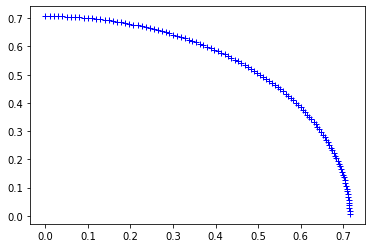

In [120]:
def ff(x, y):
    return (x**2 + y**2 - 0.5 )
def g1(x, y):
    return(x**2 + x*y - y**2)
def g2(x, y):
    return(x + y -0.25)

print(simple_contour(ff, 1))

xs, ys = simple_contour(ff, 0.0)
plt.plot(xs, ys, "+", color = 'blue')
plt.show()


#### Commentaire

On obtient pas exactement l'équation de cercle attendue, il y a sûrement des dérives au fur et à mesure de la construction des points. 

## V. Elaboration du *Contour Complexe*

L'idée principale de ce projet est de paver R² (en partie) avec des carrés délimités grâce à deux listes Xc et Yc.
On souhaite appliquer simple_contour sur chacun de ces pavés, et ce à partir de chaque frontière du carré, et plus seulement celle de gauche. <br>
Une **hypothèse simplificatrice** est ici de dire qu'on suppose ces carrés suffisament petit pour ne tomber sur qu'une seule courbe de niveau, qui ne se plie pas trop. Un cas pathologique typique serait d'avoir deux points de valeurs c sur une frontière, ce qui empêcherait find_seed de bien fonctionner. On eclue ces cas-là, quitte à diminuer le pas.


Afin de pouvoir utiliser simple_contour sur ces nouveaux carrés, et depuis les quatre frontières, on introduit dans contour_complex des **translations/dilatations**, pour se ramener au carré considéré depuis le carré [0, 1] X [0, 1]. La translation dépend de i et j : il faut se décaler dans le pavage de i carrés selon les abcisses et de j selon les ordonnées.<br> On implemente de plus une fonction **rotation**, que l'on appliquera 3 fois pour aplliquer simple_contour aux trois autres frontières. Celle-ci est plus dur à réaliser, nous en détaillon le fonctionnement ci-dessous.<br> Il faudra ensuite effectuer les transformations inverses, puis ajouter les points obtenus dans deux listes d'abcisses et d'ordonnées.

**Rotation** <br>
Le principe est d'effectuer une translation pour exprimer les point d'un carré dans un repère dont l'origine est le centre du carré. On obtient ensuite le module et argument de ce point en coordonnées polaires dans ce nouveau repère, grâce à la fonction arctangente, en distinguant les cas 'x' > 0 et 'x' < 0. On ajoute rot * pi/2 à ce dernier, si l'on veut tourner 'rot' fois le carré sur lui-même. On obtient un point de même module mais pivoté.


In [121]:
def rotation(x, y, pas, i):                      #pas est la longueur du côté du carré
    x, y = x - pas/2, y - pas/2 
    h = (x, y)
    if x == 0:
        return (-y + pas/2, pas/2)
    if x > 0:
        return (norm(h)*np.cos(np.arctan(y/x) + i*np.pi/2) + pas/2, norm(h)*np.sin(np.arctan(y/x) + i*np.pi/2) + pas/2)
    else:
        return (norm(h)*np.cos(np.arctan(y/x) + (2 + i)*np.pi/2) + pas/2, norm(h)*np.sin(np.arctan(y/x) + (2 + i)*np.pi/2) + pas/2)
    
#On teste le fonctionnement   
rotation(0.4, 0.6, 1.0, 1), rotation(0.6, 0.6, 1.0, 4), rotation(0.4, 0.2, 1.0, 4), rotation(0.6, 0.1, 1.0, 4)


((0.4, 0.4), (0.6, 0.6), (0.3999999999999999, 0.2), (0.6, 0.09999999999999992))

In [122]:
def contour_complex(f, c = 0.0, Xc = [0.0, 1.0], Yc = [0.0, 1.0], delta = 0.01):
    Xs = [] 
    Ys = [] 
    pas = Xc[1] - Xc[0]              #on suppose un pas constant dans la liste Xc et Yc, soit des carrés de tailles égales
    
    #On souhaite parcourir un à un tous les carrés du pavage.
    for i in range(len(Xc) - 1):
        for j in range(len(Yc) - 1):
            
            #on boucle pour effectuer les 4 rotations  
            for rot in range(3): 
                
                #on définit une fonction à valeur dans [0, 1] X [0, 1] et qui renvoit grâce à une translation et dilatation 
                #les valeurs de f dans le carré [Xc[i], Xc[i+1]] X [Yc[i], Yc[i+1]] que l'on a tourné d'un angle rot*pi/2.
                def g(x, y):   
                    x_new = x * pas + i * pas
                    y_new = y * pas + j * pas
                    rot_before = rotation(x_new, y_new, pas, rot)
                    return f(rot_before[0], rot_before[1])
                         
                #on applique simple contour, on obtient des points de [0, 1] X [0, 1]     
                X_int_1, Y_int_1 = simple_contour(g, c, delta)
                                               
                #il faut encore tourner ces points et les ramener au bon carré:
                X_int_2, Y_int_2 = [], []                                 
                for x, y in zip(X_int_1, Y_int_1):
                    
                    #on fait tourner d'autant dans le même sens, pour retomber sur l'orientation qui a effectivement été utilisée 
                    #dans simle_contour
                    rot_after = rotation(x, y, pas, rot) 
                    X_int_2.append((rot_after[0] + i)*pas)          
                    X_int_2.append((rot_after[1] + j)*pas) 
                    
                #On ajoute enfin les points trouvés
                Xs.append(X_int_2) 
                Ys.append(Y_int_2)
    return Xs, Ys
        

## VI. Tracé du Contour

#### Tracé de simple_contour

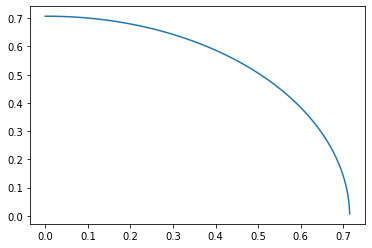

In [123]:
X, Y = simple_contour(ff, c = 0, delta = 0.01)
plt.plot(X, Y)
plt.show()




#### tracé de contour_complex

In [128]:
def f(x, y):
    return np.exp(x**2 - y**2 + 1)
def g(x, y):
    return np.exp(- (x - 1)**2 - (y - 1)**2)

def function(x, y):                  #Voici la fonction présentée en exemple dans le sujet.
    return 2*(f(x, y) - g(x, y))
print(contour_complex(function, c = 0, delta = 0.01))

#Xs, Ys = contour_complex(function, c = 0, delta = 0.01)
#for x, y in zip(Xs, Ys):
#    plt.plot(x, y)
#plt.show()


([[], [], []], [[], [], []])


**Commentaire** On ne réussit pas à tracé la fonction demandée, on obtient la bonne structure (liste de listes) mais sans les points dedans. Il faudrait ensuite tester avec Xc et Yc differents des valeurs par défault.

## ANNEXES : Erreurs et étapes de raisonnement.


**simple_contour**: Nous avons eu trois idées succesives pour simple_contour:
>**I** La première a été tout d'abord d'utiliser le **Théorème des fonctions implicites** afin de déterminer localement l'existence d'une fonction $\Psi$ de x donnant la valeur de y = $\Psi$(x). Ce théorème propose une expression de la diférentielle de $\Psi$, si elle existe (différentielle partielle par rapport à y inversible en ce point) . Il s'agissait donc d'en vérifier l'existence, puis d'obtenir la dérivée de psi, égale à sa différentielle puisque la fonction f étudiée est de R² dans R². On obtenant les valeurs de y en augmentant la valeur de l'abcisse de 'delta' en 'delta'et en déduisant les valeurs de y en approximant psi par segment grâce à sa dérivée en chaque point. <br>
**PROBLEME:** On peut obtenir l'existence d' une fonction psi en chaque point mais *on n'a pas unicité*. On ne peut dés lors pas déduire psi(x0 + delta) à partir de psi(X0), les deux psi étant en fait différentes. De plus, le fait d'augmenter la valeur de x de la même valeur à chaque fois n'est pas réaliste, selon les courbures de la courbe de niveau, on peut dans le meilleur cas perdre en précision et ne pas avoir du tout une distance delat entre chaque point, au pire des cas ne pas être capable de rendre compte d'une courbe qui rebrousse chemin par exemple. <br> <br>
**II** La seconde option utilisait déjà le fait que le gradient en un point est orthogonal aux courbes de niveau, mais nous n'allions pas plus en précsion. Voici une version intermédiaire. Nous avions déjà implementé le choix du prochain point parmis les deux situés sur la droite orthoganale au gradient en le point précédent, et situés à une distance delta de l'antépénultieme point, ceci afin d'être sûr de ne pas revenir sur nos pas.

In [113]:
def simple_contour(f,c=0.0,delta=0.01):
    x,y = [],[]
    y_init = find_seed(f, c, eps=2**(-26))
    if type(y_init) == float:     #nous avons changé depuis le test pour savoir si find_seed renvoie une racine sur la frontière gauche
        x.append(0.0)
        y.append(y_init)
        i=0
        nb_test=0
        while nb_test<10:
            grad_f = grad(f, x[i], y[i])
            if norm(grad_f) != 0.0 :
                next_point_d_x = x[i] + grad_f[1]*delta/norm(grad_f)
                next_point_d_y = y[i] - grad_f[0]*delta/norm(grad_f) 
                next_point_g_x = x[i] - grad_f[1]*delta/norm(grad_f)
                next_point_g_y = y[i] + grad_f[0]*delta/norm(grad_f) 
                if norm((next_point_d_x - x[i-1], next_point_d_y - y[i-1])) < norm((next_point_g_x - x[i-1], next_point_g_y - y[i-1])) and 0 <= next_point_g_x <=1 and 0 <= next_point_g_y <= 1:
                #au lieu de considérer les deux points qu'on peut obtenir à partir de la méthode de la tangente, on prend que les points pour lesquels x augmente 0 <= next_point_d_x <=1 and 0 <= next_point_d_y <= 1:
                    x.append(next_point_g_x)
                    y.append(next_point_g_y)
                    i += 1    
                elif norm((next_point_d_x - x[i-1], next_point_d_y - y[i-1])) >= norm((next_point_g_x - x[i-1], next_point_g_y - y[i-1])) and 0 <= next_point_d_x <=1 and 0 <= next_point_d_y <= 1: 
                    x.append(next_point_d_x)
                    y.append(next_point_d_y)
                    i += 1                 
            nb_test+=1
    return (x, y)
    

Nous pensions alors gagner en précision en nous plaçant sur l'abcisse du point trouvé, mais **en refaisant une méthode** de Newton (de R vers R) ou une dichotomie, pour trouver une valeur plus précise de l'ordonné du point de la ligne de niveau. Nous n'avons pas implémenter cette méthode, qui nous parraissait juste, car nous avons pensé à créer la fonction <br> 
                                    g: (x, y) $\in$ R² $\rightarrow$ (f(x, y), 0)  <br>
pour utiliser une méthode de newton de R² vers R², et trouver le point suivant grâce à la jacobienne de la fonction en un point.

#### contour_complexe


Pour cette fonction nous pensions dans une premier temps modifier contour_simple et lui faire prendre en argument l'abcisse et l'ordonné du coin haut gauche du carré étudié, sa taille, et la frontière dont on voulait partir. Cela nous parraissait en fait trop compliquer cette fonction. Il était à la fois plus élégant et plus cohérent de traduire des transformations géométriques mathématiquement et de les appliquer pour se ramener au contexte normal d'utilisation de contour_simple: carré [0, 1] X [0, 1] et arrête gauche pour amorcer la recherche.